# Urban Sound Classification

## Mounting Drive

In [1]:
# mount drive with data
from google.colab import drive
drive.mount('/content/gdrive')
# data download link - https://goo.gl/8hY5ER

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Importing Libraries

In [ ]:
# librosa for sound processing
!pip install librosa==0.7.2

# for augmentation
!pip install pyrubberband

# seaborn
!pip install seaborn==0.10.0

#numba
!pip install numba==0.48

In [5]:
# importing libraries
import glob
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow import keras
import numpy as np
import pandas as pd
import librosa.display
from tqdm import tqdm
import pickle as pkl

import random
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, display

import pyrubberband as pyrb
import re
import six
from copy import deepcopy

import keras
import soundfile as sf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from keras.utils import np_utils
from keras.regularizers import l2
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from keras.utils.np_utils import to_categorical

## Data Preprocessing

In [15]:
metadata = pd.read_csv("/content/gdrive/My Drive/UrbanSound8K/metadata/UrbanSound8K.csv")
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [16]:
sound_clip, sr = librosa.load("/content/gdrive/My Drive/UrbanSound8K/audio/fold5/100263-2-0-117.wav")
print(sound_clip.shape)

(88200,)


In [17]:
def standard_process(y, sr=22050):
  mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=36).T,axis=0)
  melspectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=36,fmax=8000).T,axis=0)
  chroma_stft=np.mean(librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=36).T,axis=0)
  chroma_cq = np.mean(librosa.feature.chroma_cqt(y=y, sr=sr,n_chroma=36).T,axis=0)
  chroma_cens = np.mean(librosa.feature.chroma_cens(y=y, sr=sr,n_chroma=36).T,axis=0)
  features=np.reshape(np.vstack((mfccs,melspectrogram,chroma_stft,chroma_cq,chroma_cens)),(36,5))
  return features.reshape(36, 5, 1)

In [ ]:
#preprocessing using entire feature set
path="/content/gdrive/My Drive/UrbanSound8K/audio/fold"
processed_data = {}
processed_metadata = {}

for i in tqdm(range(len(metadata))):
    fold_no = str(metadata.iloc[i]["fold"])
    file_name = metadata.iloc[i]["slice_file_name"]
    label = metadata.iloc[i]["classID"]
    file_path = path + fold_no + "/" + file_name
    
    sound_clip, sr = librosa.load(file_path)
    log_specgrams = standard_process(sound_clip)

    if processed_data.get(fold_no) == None:
      processed_data[fold_no] = []
    processed_data[fold_no].append((log_specgrams, label))
    if processed_metadata.get(fold_no) == None:
      processed_metadata[fold_no] = []
    processed_metadata[fold_no].append((file_path, label))

In [ ]:
# with open("/content/gdrive/My Drive/UrbanSound8K/processed_data.pickle","wb") as f:
#   pkl.dump(processed_data,f)

# with open("/content/gdrive/My Drive/UrbanSound8K/processed_metadata.pickle","wb") as f:
#   pkl.dump(processed_metadata,f)

## Augmentation

### Time Stretching

In [1]:
# Time stretching
def time_stretching(rate, sound_clip):
  sound_clip = librosa.effects.time_stretch(sound_clip, rate = rate)
  return standard_process(sound_clip)

### Pitch Shifting

In [2]:
# Pitch shifting
def pitch_shifting(tone_step, sound_clip, sr=22050):
  sound_clip = librosa.effects.pitch_shift(sound_clip, sr, n_steps = tone_step)
  return standard_process(sound_clip)

### Noise Addition

In [3]:
# Noise Addition
def add_noise(sound_clip):
    noise = np.random.rand(len(sound_clip))
    noise = np.ones(len(sound_clip))
    noise_amp = np.random.uniform(0.005, 0.008)
    noisy_sound_clip = sound_clip + (noise_amp * noise)
    return standard_process(noisy_sound_clip)

### Examples

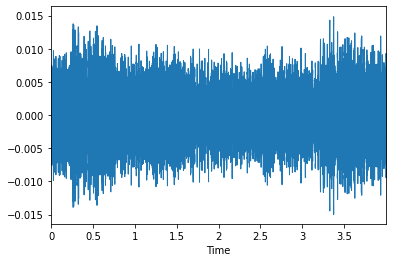

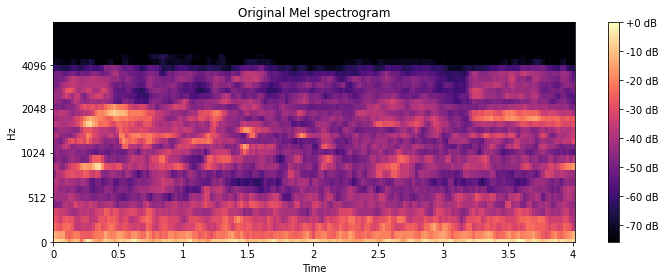

In [14]:
filename = "/content/gdrive/My Drive/UrbanSound8K/audio/fold5/100263-2-0-137.wav"
y, sr = librosa.load(filename)
librosa.display.waveplot(y, sr=sr)
signal = y
melspec = librosa.feature.melspectrogram(signal, n_mels = 36)
plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.amplitude_to_db(melspec,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Mel spectrogram')
plt.tight_layout()

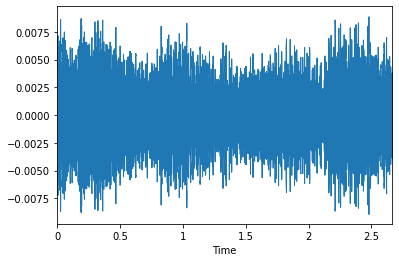

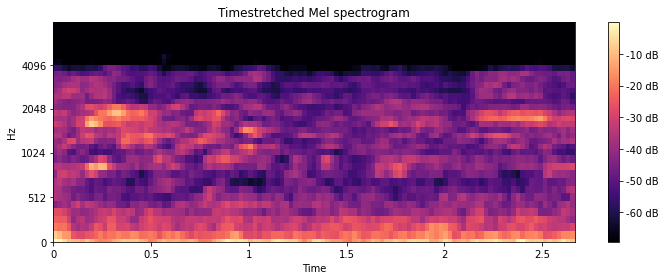

In [13]:
sound_clip = librosa.effects.time_stretch(y, rate = 1.5)
librosa.display.waveplot(sound_clip, sr=sr)
signal = sound_clip
melspec = librosa.feature.melspectrogram(signal, n_mels = 36)
plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.amplitude_to_db(melspec,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Timestretched Mel spectrogram')
plt.tight_layout()

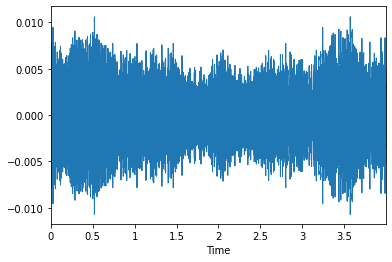

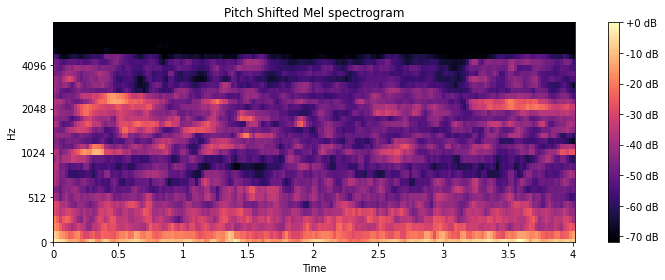

In [12]:
sound_clip = librosa.effects.pitch_shift(y, sr, n_steps = 3.5)
librosa.display.waveplot(sound_clip, sr=sr)
signal = sound_clip
melspec = librosa.feature.melspectrogram(signal, n_mels = 36)
plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.amplitude_to_db(melspec,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Pitch Shifted Mel spectrogram')
plt.tight_layout()

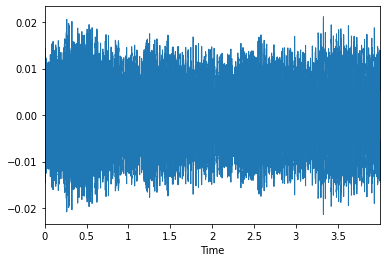

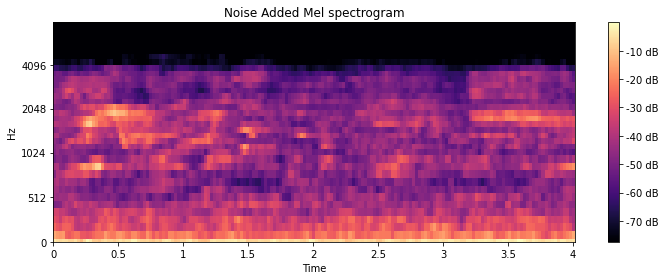

In [11]:
def get_noisy_sound(sound_clip):
    noise = np.random.rand(len(sound_clip))
    noise = np.ones(len(sound_clip))
    noise_amp = np.random.uniform(0.005, 0.008)
    noisy_sound_clip = sound_clip + (noise_amp * noise)
    return noisy_sound_clip

sound_clip = get_noisy_sound(y)
librosa.display.waveplot(sound_clip, sr=sr)
signal = sound_clip
melspec = librosa.feature.melspectrogram(signal, n_mels = 36)
plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.amplitude_to_db(melspec,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Noise Added Mel spectrogram')
plt.tight_layout()

## Data Generator

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, train_metadata, batch_size=32*4):
        'Initialization'
        self.batch_size = batch_size
        self.train_metadata = train_metadata
        self.dim = (36, 5)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor((len(self.train_metadata)*4) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        temp_metadata = []
        for k in range(0, len(indexes), 4):
          temp_metadata.append(self.train_metadata[indexes[k] // 4])

        # Generate data
        X, Y = self.__data_generation(temp_metadata)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.train_metadata))

    def __data_generation(self, temp_metadata):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, 1))
        Y = np.empty((self.batch_size), dtype=int)
        idx = 0

        # Generate data
        for id, data in enumerate(temp_metadata):
            label = int(data[1])
            sound_clip, sr = librosa.load(data[0])

            original = standard_process(sound_clip)
            
            X[idx,] = original
            Y[idx] = label
            idx += 1

            # time shifted
            rates = [1.5]
            for rate in rates:
              time_stretched = time_stretching(rate, sound_clip)
              X[idx,] = time_stretched
              Y[idx] = label
              idx += 1

            # pitch shifted
            tone_steps = [2]
            for tone_step in tone_steps:
              pitch_shifted = pitch_shifting(tone_step, sound_clip)
              X[idx,] = pitch_shifted
              Y[idx] = label
              idx += 1
            
            # noise added
            noisy_sound = add_noise(sound_clip)
            X[idx,] = noisy_sound
            Y[idx] = label
            idx += 1

        return X, to_categorical(Y, num_classes=10)

## CNN Model

In [19]:
# paper model translated
def get_model():
  #forming model
  model=Sequential()

  #adding layers and forming the model
  model.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(36, 5, 1)))
  model.add(MaxPooling2D(padding="same"))

  model.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
  model.add(MaxPooling2D(padding="same"))
  model.add(Dropout(0.3))

  model.add(Flatten())

  model.add(Dense(256,activation="relu"))
  model.add(Dropout(0.4))

  model.add(Dense(512,activation="relu"))
  model.add(Dropout(0.4))

  model.add(Dense(10,activation="softmax"))

  #compiling
  model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

  return model

## 10 Fold Cross Validation

In [20]:
with open("/content/gdrive/My Drive/UrbanSound8K/processed_data.pickle","rb") as f:
  processed_data = pkl.load(f)

with open("/content/gdrive/My Drive/UrbanSound8K/processed_metadata.pickle","rb") as f:
  processed_metadata = pkl.load(f)

In [24]:
with open("x_data.pickle","rb") as f:
  x_data = pkl.load(f)

with open("y_label.pickle","rb") as f:
  y_label = pkl.load(f)

In [25]:
X = []
Y = []
for i in range(10):
  xi = np.array(x_data[i])

  #reshaping to shape required by CNN
  xi_cnn = np.reshape(xi,(xi.shape[0],xi.shape[1],xi.shape[2], 1))
  X.append(xi_cnn)

  yi = to_categorical(y_label[i], num_classes=10)
  Y.append(yi)

In [26]:
X[0].shape, Y[0].shape

((873, 36, 5, 1), (873, 10))

In [ ]:
sum_train_loss = 0
sum_test_loss = 0
sum_train_acc = 0
sum_test_acc = 0

results = np.zeros((10, 4))

for i in range(10):
  model = get_model()

  x_train = np.concatenate([X[j] for j in [k for k in range(10) if k not in [i]]])
  y_train = np.concatenate([Y[j] for j in [k for k in range(10) if k not in [i]]])

  x_test = X[i]
  y_test = Y[i]

  train_metadata = [processed_metadata[str(k+1)] for k in range(10) if k not in [i]]
  # flatten
  train_metadata = [item for sublist in train_metadata for item in sublist]

  # Generators
  training_generator = DataGenerator(train_metadata)

  # fit with increased data (original + augmented) 
  model.fit(training_generator, epochs=30, use_multiprocessing=True, workers=8)

  #test loss and scores respectively on original train and test
  train_eval = model.evaluate(x_train, y_train)
  test_eval = model.evaluate(x_test, y_test)

  print("Results for folder: ", i)
  print(train_eval)
  print(test_eval)

  sum_train_loss += train_eval[0]
  sum_test_loss += test_eval[0]
  sum_train_acc += train_eval[1]
  sum_test_acc += test_eval[1]

  results[i][0] = train_eval[0]
  results[i][1] = test_eval[0]
  results[i][2] = train_eval[1]
  results[i][3] = test_eval[1]

  with open("/content/gdrive/My Drive/UrbanSound8K/results.pickle","wb") as f:
    pkl.dump(results, f)

# Results

In [ ]:
print("Avg Train Loss: ", sum_train_loss/10)
print("Avg Train Acc: ", sum_train_acc/10)
print("Avg Test Loss Score: ", sum_test_loss/10)
print("Avg Test Loss Acc: ", sum_test_acc/10)